**MACHINE LEARNING IN BUSINESS** 

**Objective** - find the best place for a new well.

Steps to choose the location:

- Collect the oil well parameters in the selected region: oil quality and volume of reserves;
- Build a model for predicting the volume of reserves in the new wells;
- Pick the oil wells with the highest estimated values;
- Pick the region with the highest total profit for the selected oil wells.

You have data on oil samples from three regions. Parameters of each oil well in the region are already known. Build a model that will help to pick the region with the highest profit margin. Analyze potential profit and risks using the Bootstrapping technique.



**Data sources**

- 3 csv files for 3 regions
- id — unique oil well identifier
- f0, f1, f2 — three features of points (their specific meaning is unimportant, but the features themselves are significant)
- product — volume of reserves in the oil well (thousand barrels).



In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

In [2]:
df0 = pd.read_csv('geo_data_0.csv')
df1 = pd.read_csv('geo_data_1.csv')
df2 = pd.read_csv('geo_data_2.csv')

**PRIMARY DATA PREPROCESSING**

In [10]:
def get_info(df):
    print(f'Number of duplicates = {df.duplicated().sum()}')
    print('Distribution of features')
    display(df.describe())
    print('Missing values')
    display(df.isna().sum())
    print('Product distribution')
    df['product'].plot(kind = 'hist', bins = 10)

Number of duplicates = 0
Distribution of features


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Missing values


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Product distribution


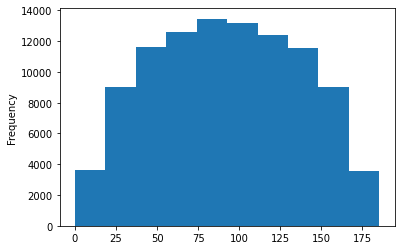

In [11]:
get_info(df0)

Number of duplicates = 0
Distribution of features


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Missing values


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Product distribution


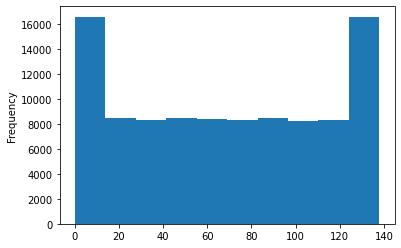

In [12]:
get_info(df1)

Number of duplicates = 0
Distribution of features


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Missing values


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Product distribution


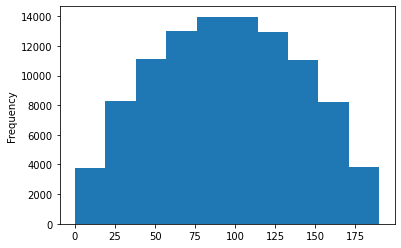

In [13]:
get_info(df2)

**Conclusion**

- no duplicates, missing values and outliers
- distribution for region_1 differs from region_0 and region_2 - more often we have oil wells with either very low or very high concentration of product

**PREDICTION**

Only linear regression is suitable for model training (the rest are not sufficiently predictable).

In [15]:
def get_prediction(df):
    state = np.random.RandomState(54321)
    df = df.drop('id', axis = 1)
    target = df['product']
    features = df.drop('product', axis = 1)
    target_train, target_valid, features_train, features_valid = train_test_split(target, features, test_size = 0.25, random_state = state)
    scaler = StandardScaler()
    features_train = scaler.fit_transform(features_train)
    features_valid = scaler.transform(features_valid)
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    print(f'rmse : {mean_squared_error(predicted_valid, target_valid)**0.5}')
    print(f'average prediction: {pd.Series(predicted_valid).mean()}')
    return pd.Series(predicted_valid), pd.Series(target_valid).reset_index(drop = True)



In [17]:
predicted0, target0 = get_prediction(df0)

rmse : 37.68341093860808
average prediction: 92.15921155743655


In [19]:
predicted1, target1 = get_prediction(df1)

rmse : 0.8922819708481483
average prediction: 68.44594093153303


In [20]:
predicted2, target2 = get_prediction(df2)

rmse : 40.15250541784855
average prediction: 94.92229500787454


**Conclusion** 

Region_2 has the highest average but, on the other hand, the highest rmse We will use bootstrap to make the final conclusion

**PROFIT CALCULATION**

When exploring the region, a study of 500 points is carried with picking the best 200 points for the profit calculation.

In [25]:
budget = 100000000
number_wells = 200
price_product = 4500

In [30]:
def get_profit_top_200(predicted, target):
    predicted = predicted.sort_values(ascending = False).head(number_wells)
    target = target[predicted.index]
    revenue = target.sum()*price_product
    profit = round(((revenue - budget)/1000000), 2)
    return profit

Check function for all oil wells

In [31]:
all_predictions = pd.concat([predicted0, predicted1, predicted2])
all_targets = pd.concat([df0['product'], df1['product'], df2['product']])

In [33]:
print(f'Profit from top_{number_wells} in all regions = {get_profit_top_200(all_predictions, all_targets)} USD million')

Profit from top_200 in all regions = 126.83 USD million


**BOOTSTRAP**

Find average profit, 95% confidence interval and risk of losses. Loss is negative profit, calculate it as a probability and then express as a percentage.

In [49]:
def get_mean_profit(predicted, target, region):

    state = np.random.RandomState(54321)
    n_bootstrap = 1000
    bootstrap_size = 500
    profits = []
    for i in range(n_bootstrap):
        bootstrap_sample = predicted.sample(bootstrap_size, replace = True, random_state = state)
        profit = get_profit_top_200(bootstrap_sample, target)
        profits.append(profit)
    profits = pd.Series(profits)
    lower = profits.quantile(0.025)
    upper = profits.quantile(0.975)
    losses = len(profits[profits <0])/len(profits)*100
    print(f'Average profit for {region} = {round(profits.mean(), 2)} USD million, confidence interval ({round(lower, 2)}, {round(upper, 2)}) Losses = {round(losses, 1)} %')





In [51]:
get_mean_profit(predicted0, target0, 'region_0')

Average profit for region_0 = 3.78 USD million, confidence interval (-0.9, 9.02) Losses = 6.8 %


In [52]:
get_mean_profit(predicted1, target1, 'region_1')

Average profit for region_1 = 4.11 USD million, confidence interval (0.18, 8.35) Losses = 2.1 %


In [54]:
get_mean_profit(predicted2, target2, 'region_2')

Average profit for region_2 = 3.97 USD million, confidence interval (-1.4, 8.77) Losses = 7.6 %


**Conclusion**

The most promising region - region_1